## Pacotes

In [146]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import random

# Diretório


In [147]:
diretorio = r'C:\Users\JoãoPinheiro\OneDrive - CTI Global\Área de Trabalho\dados_reviews'
diretorio = diretorio.replace('\\','/')
os.chdir(diretorio)


# Conjunto de dados
https://www.kaggle.com/datasets/kmldas/apple-iphone-se-reviews-ratings


In [148]:
dados = pd.read_csv('https://raw.githubusercontent.com/jrodrigotico/TF-IDF-Reviews/main/iphone_se.csv')
dados.columns

Index(['Ratings', 'Comment', 'Reviews'], dtype='object')

# Renomeação de colunas


In [149]:
dados = dados[['Ratings','Comment']]
dados.columns = ['score','avaliacao_texto']
dados['avaliacao_texto'] = dados['avaliacao_texto'].astype('string')



## Tratamento dos dados


In [150]:
# Retirando linhas sem review na coluna 'avaliacao_texto'
dados.dropna(subset=['avaliacao_texto'], inplace=True)

# Retirada de pontuação
def retirar_pontuacao(texto):
    return re.sub(r'[^\w\s]','', texto)

dados['avaliacao_new'] = dados['avaliacao_texto'].apply(func = retirar_pontuacao)

# Retirada de 'stopwords'
stopwords = set(nltk.corpus.stopwords.words('english'))
def retirar_stopwords(linha):
    palavra_limpa = [i for i in linha.split() if i.lower() not in stopwords] # aqui resulta em uma nova lista # [expressao for item in iterable if condicao]
    return ' '.join(palavra_limpa) # aqui as palavras sao separadas por espaço em branco

dados['avaliacao_new'] = dados['avaliacao_new'].apply(func = retirar_stopwords) 


In [151]:
# Stemming
nltk.download('punkt')
stemmer = PorterStemmer()

def stemming(frase):
    palavra_token = word_tokenize(frase) # tokenização, ou seja, faz a quebra os caracteres
    palavra_stemming = [stemmer.stem(i) for i in palavra_token] # faz o stemming em cada palavra
    return ' '.join(palavra_stemming)

dados['avaliacao_new'] = dados['avaliacao_new'].apply(func = stemming)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoãoPinheiro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vetorização
Cada linha da tabela 'tfidf_tabela' representa uma avaliação e cada coluna representa uma palavra.

Aqui serão gerados os pesos de cada palavra em cada review.

In [152]:
vetor = TfidfVectorizer()
tfidf = vetor.fit_transform(dados['avaliacao_new']) # o tfidf será usado no Naive-Bayes
palavras = vetor.get_feature_names_out()
tfidf_tabela = pd.DataFrame(tfidf.toarray(), columns = palavras)


## Palavras mais frequentes
São as palavras com maior peso.


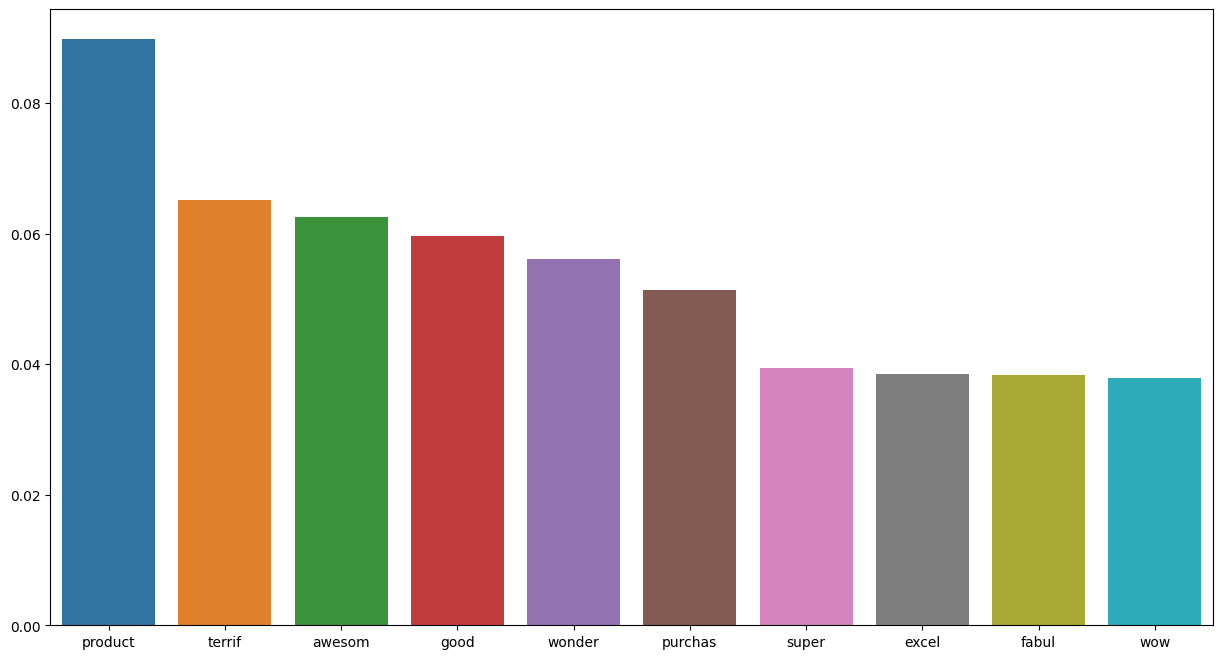

In [153]:
# Média de cada coluna e filtrando alguma quantidade de  palavras com maior média dos pesos em cada review
mean = tfidf_tabela.mean(axis=0)

def mean_top (numero):
    mean_top = pd.DataFrame(round(mean.nlargest(numero),4), columns=['mean']).T
    return sns.barplot(data = mean_top).figure.set_size_inches(15,8)

# modificar número
mean_top(10)


# K-means
Precisa-se chegar a um número ideal de clusters, plotar gráfico, analisar SSE.

In [154]:
# # Clusters (K-means) - método não-supervisionado
# k = 10
# kmeans = KMeans(n_clusters=k, random_state=111)
# kmeans.fit(tfidf_tabela)
# labels = kmeans.labels_
# dados['etiquetas_cluster'] = labels


# Naive Bayes Multinomial
Indicado para casos em que a variável dependente não é binária. Nesse caso a variável 'score' é uma nota de 1 a 5.

In [155]:
# Base treino (80%) e teste (20%)
y = dados['score']
treino_x, teste_x, treino_y, teste_y = train_test_split(tfidf, y, test_size=0.2, random_state=111)

In [156]:
naive_bayes = MultinomialNB()
naive_bayes.fit(treino_x, treino_y)
predicts = naive_bayes.predict(teste_x)

acuracia = accuracy_score(teste_y, predicts)
print('Acurácia: ', acuracia)

relatorio = classification_report(teste_y, predicts)
print(relatorio)

Acurácia:  0.9469891919711786
              precision    recall  f1-score   support

           1       0.99      0.89      0.94        98
           2       0.95      0.84      0.89        44
           3       0.82      0.64      0.72        94
           4       0.87      0.90      0.89       354
           5       0.97      0.99      0.98      1353

    accuracy                           0.95      1943
   macro avg       0.92      0.85      0.88      1943
weighted avg       0.95      0.95      0.95      1943

